In [34]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
data = loadmat('ecg_dataset.mat')
print(data.keys())
print('------------------')
data

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
------------------


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Aug 26 17:46:48 2025',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-0.61 , -0.61 , -0.595, ..., -0.83 , -0.81 , -0.81 ],
        [-0.355, -0.375, -0.365, ...,  0.   ,  0.   ,  0.   ],
        [-0.26 , -0.26 , -0.25 , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [-0.23 , -0.235, -0.2  , ...,  0.   ,  0.   ,  0.   ],
        [ 0.15 ,  0.185,  0.195, ...,  0.   ,  0.   ,  0.   ],
        [-0.24 , -0.24 , -0.23 , ...,  0.   ,  0.   ,  0.   ]]),
 'y': array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

In [4]:
X = data['X']
Y = data['y'].flatten()
classe, count = np.unique(Y,return_counts=True)
for c, n in zip(classe, count):
    print(f"Classe {c} : {n} échantillons")

Classe 0 : 5288 échantillons
Classe 1 : 111 échantillons
Classe 2 : 6 échantillons


index = 0
index = 2
index = 1148


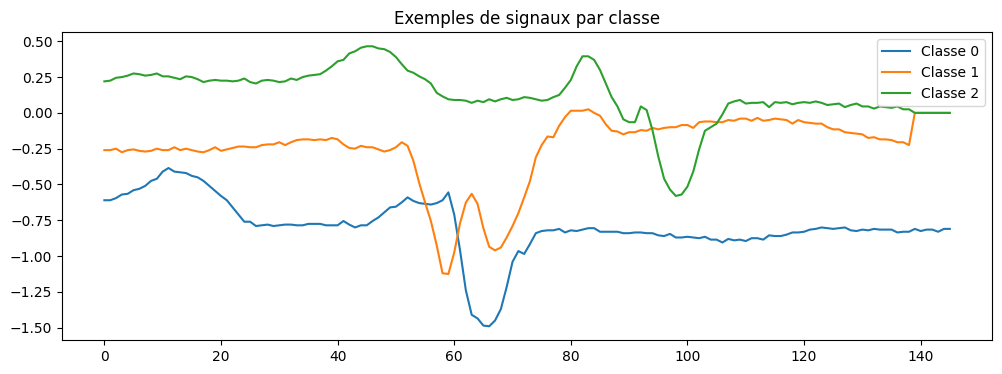

In [5]:
plt.figure(figsize=(12,4))
for c in [0, 1, 2]:
    idx = np.where(Y == c)[0][0] 
    print(f'index = {idx}')
    plt.plot(X[idx], label=f'Classe {c}')
plt.legend()
plt.title("Exemples de signaux par classe")
plt.show()

# Normalisation des données

In [24]:
X_norm =(X- X.mean(axis=1, keepdims=True))/(X.std(axis=1, keepdims=True)+1e-8)
#X_norm= (X - X.min(axis=1, keepdims=True)) / (X.max(axis=1, keepdims=True) - X.min(axis=1, keepdims=True) + 1e-8)

X_norm

array([[ 0.93153123,  0.93153123,  1.00821055, ..., -0.19309884,
        -0.09085975, -0.09085975],
       [ 0.23055808,  0.13724836,  0.18390322, ...,  1.88680549,
         1.88680549,  1.88680549],
       [-0.08324134, -0.08324134, -0.04218311, ...,  0.98427256,
         0.98427256,  0.98427256],
       ...,
       [ 0.11195021,  0.08362312,  0.28191276, ...,  1.41499637,
         1.41499637,  1.41499637],
       [ 0.25212855,  0.39560037,  0.43659231, ..., -0.36275065,
        -0.36275065, -0.36275065],
       [ 0.24736046,  0.24736046,  0.30039222, ...,  1.52012264,
         1.52012264,  1.52012264]])

# Recuperatioin de la classe d'entrainement classe N(0)

In [25]:
X_normal = X_norm[Y==0][:, :144]
X_anomaly_R = X_norm[Y==1][:, :144]
X_anomaly_V = X_norm[Y==2][:, :144]


In [26]:
X_training, X_validation = train_test_split(X_normal, test_size=0.2, random_state=42)
X_training = X_training[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_anomaly_R = X_anomaly_R[..., np.newaxis]
X_anomaly_V = X_anomaly_V[..., np.newaxis]


# construction de l'autoencodeur

In [36]:
data_input =(144, 1)
encoder = models.Sequential([
    layers.Input(shape=data_input),
    layers.Conv1D(8, kernel_size=7, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(16, activation='relu')  # goulot (petit latent space)
])

decoder = models.Sequential([
    layers.Dense((144 // 4) * 32, activation='relu'),
    layers.Reshape((144 // 4, 32)),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(8, kernel_size=7, activation='relu', padding='same'),
    layers.Conv1D(1, kernel_size=1, activation='linear', padding='same')
])

input_autoencodeur = layers.Input(shape = data_input)
data_encoded= encoder(input_autoencodeur)
data_decoded = decoder(data_encoded)

autoencodeur = models.Model(input_autoencodeur, data_decoded)

# compilation de l'autoencodeur

In [37]:
autoencodeur.compile(optimizer='adam', loss = 'mse')

#entrainement du models

In [38]:
training_history = autoencodeur.fit(
    X_training, X_training, epochs=50, batch_size=32,
    validation_data=(X_validation, X_validation),
    shuffle=True)

Epoch 1/50
133/133 [==============================] - 3s 12ms/step - loss: 0.2329 - val_loss: 0.0631
Epoch 2/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0377 - val_loss: 0.0275
Epoch 3/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0257 - val_loss: 0.0237
Epoch 4/50
133/133 [==============================] - 1s 10ms/step - loss: 0.0224 - val_loss: 0.0216
Epoch 5/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0202 - val_loss: 0.0194
Epoch 6/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 7/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 8/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 9/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 10/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0140 - val_lo

# calcul du scroe d'anomalie(mse)

In [39]:
def anomaly_score(model, data):
    reconstructon = model.predict(data)
    errors = np.mean((data - reconstructon)**2, axis=(1,2))
    return errors

error_N = anomaly_score(autoencodeur, X_training)
error_R = anomaly_score(autoencodeur, X_anomaly_R)
error_V = anomaly_score(autoencodeur, X_anomaly_V)

print("============ Scroe d'anomalie =============")
print(f'Normales: {error_N}')
print(f'Anomalie R: {error_R}')
print(f'Anomalie V: {error_V}')

1/1 [==============================] - 0s 22ms/step
============ Scroe d'anomalie =============
Normales: [0.005736   0.00373696 0.00764545 ... 0.00627091 0.0042859  0.00751332]
Anomalie R: [0.18201206 0.17447657 0.17781557 0.18747553 0.1695128  0.21527743
 0.18509652 0.51566995 0.1822397  0.19453452 0.22305405 0.20469457
 0.25862968 0.24046832 0.22226692 0.25556265 0.34288939 0.5623155
 0.23076815 0.22599599 0.4787381  0.16503373 0.23538892 0.21910109
 0.19343242 0.22198542 0.21653521 0.30537482 0.21342845 0.29475908
 0.1682741  0.21814204 0.23110985 0.55557802 0.24274448 0.91179332
 0.20056    0.19346853 0.21870609 0.57365805 0.32462992 0.38532102
 0.190879   0.20674369 0.33100722 0.53632443 0.17509068 0.53651226
 0.2105519  0.18058158 0.21888596 0.21971881 0.2803228  0.35913319
 0.45512215 0.18486433 0.25722746 0.2479622  0.22251902 0.17398977
 0.25607057 0.30896926 0.45338942 0.3218048  0.24191281 0.20204301
 0.25634158 0.19717873 0.26266112 0.18472699 0.13825868 0.30163668
 0.1509

# Dertermination du seuil

In [44]:
seuil = np.percentile(error_N, 90)
print('========== Seuil de detection =============')
print(f'90eme percentil sur les données normales: {seuil:.6f}')
print(f'score_errorMAX: {np.mean(error_N):.6f}')

========== Seuil de detection =============
90eme percentil sur les données normales: 0.015672
score_errorMAX: 0.009557


Visualition des score d'erreur

In [45]:
print("Erreurs max :")
print("  Normaux :", np.max(error_N))
print("  Anomalies R :", np.max(error_R))
print("  Anomalies V :", np.max(error_V))


Erreurs max :
  Normaux : 0.6148661887690126
  Anomalies R : 0.9117933220990326
  Anomalies V : 0.5732810907777781


In [49]:
seuil = np.percentile(error_N, 99)
det_N = np.sum(error_N > seuil)
det_R = np.sum(error_R > seuil)
det_V = np.sum(error_V > seuil)
print("Seuil (99e) =", seuil)
print(f"FP (normaux>seuil): {det_N}/{len(error_N)}")
print(f"R détectées: {det_R}/{len(error_R)}")
print(f"V détectées: {det_V}/{len(error_V)}")


Seuil (99e) = 0.055536504472945586
FP (normaux>seuil): 43/4230
R détectées: 111/111
V détectées: 6/6


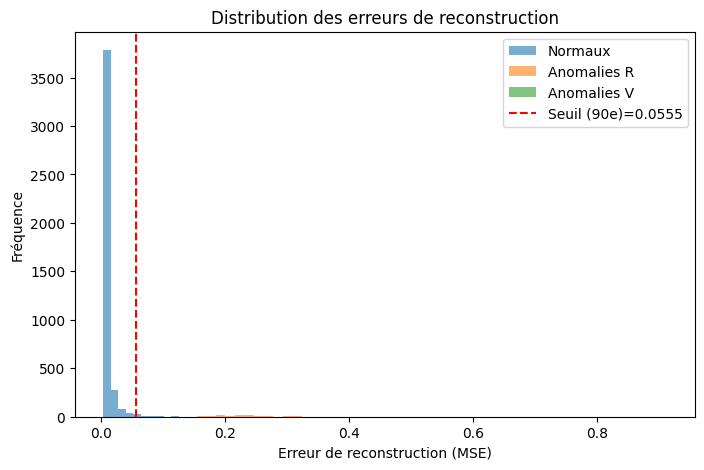

In [50]:
plt.figure(figsize=(8,5))
plt.hist(error_N, bins=50, alpha=0.6, label='Normaux')
plt.hist(error_R, bins=50, alpha=0.6, label='Anomalies R')
plt.hist(error_V, bins=50, alpha=0.6, label='Anomalies V')
plt.axvline(seuil, color='red', linestyle='--', label=f'Seuil (99e)={seuil:.4f}')
plt.xlabel("Erreur de reconstruction (MSE)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de reconstruction")
plt.legend()
plt.show()
